# Visualization Tools

This notebook contains tools to help you visualize quantum states and unitary quantum cicuits. You can find example usages below.

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, writers
from scipy.spatial.transform import Rotation as R
from braket.circuits import Circuit, FreeParameter, Observable
from braket.devices import LocalSimulator
from IPython.display import HTML

def _rotated_bloch_sphere(ax, quaternion, tracked_points=np.array([]), show=False, coords=True):
    # Create a unit sphere
    phi_vals, theta_vals = np.mgrid[0.0:2.0 * np.pi:1000j, 0.0:np.pi:500j]
    x = np.sin(theta_vals) * np.cos(phi_vals)
    y = np.sin(theta_vals) * np.sin(phi_vals)
    z = np.cos(theta_vals)

    # Specify the desired points
    points = np.array([
        [1, 0, 0],
        [-1, 0, 0],
        [0, 1, 0],
        [0, -1, 0],
        [0, 0, 1],
        [0, 0, -1]
    ])

    # Plot the unit sphere
    ax.plot_surface(x, y, z, color='grey', alpha=0.4)

    # Rotate points on the sphere
    rotated_points = R.from_quat(quaternion).apply(points)

    # Plot rotated points
    ax.scatter(rotated_points[:, 1], rotated_points[:, 0], rotated_points[:, 2], color='r', s=25, label='Cardinal directions')
    for point, label in zip(rotated_points, [r'|+$\rangle$', r'|-$\rangle$', r'|+y$\rangle$', r'|-y$\rangle$', r'|0$\rangle$', r'|1$\rangle$']):
        ax.text(point[1], point[0], point[2], label, fontsize=9, color='r')

    ib = 1 / np.sqrt(2)

    ib_points = np.array([
        [ib, ib, 0],
        [-ib, ib, 0],
        [ib, -ib, 0],
        [-ib, -ib, 0],
        [0, ib, ib],
        [0, -ib, ib],
        [0, ib, -ib],
        [0, -ib, -ib],
        [ib, 0, ib],
        [-ib, 0, ib],
        [ib, 0, -ib],
        [-ib, 0, -ib]
    ])

    # Rotate in-betweener points
    rotated_ib_points = R.from_quat(quaternion).apply(ib_points)

    # Plot rotated in-betweener points
    ax.scatter(rotated_ib_points[:, 1], rotated_ib_points[:, 0], rotated_ib_points[:, 2],
               color='black', alpha=0.5, s=3, label='In-between points')

    ibb = 1 / np.sqrt(3)

    ibb_points = np.array([
        [ibb, ibb, ibb],
        [ibb, ibb, -ibb],
        [ibb, -ibb, ibb],
        [ibb, -ibb, -ibb],
        [-ibb, ibb, ibb],
        [-ibb, ibb, -ibb],
        [-ibb, -ibb, ibb],
        [-ibb, -ibb, -ibb]
    ])

    # Rotate in-betweener points
    rotated_ibb_points = R.from_quat(quaternion).apply(ibb_points)

    # Plot rotated in-between points
    ax.scatter(rotated_ibb_points[:, 1], rotated_ibb_points[:, 0], rotated_ibb_points[:, 2],
               color='black', alpha=0.5, s=2, label='In-betweener points')

    if len(tracked_points) > 0:
        magnitudes = np.linalg.norm(tracked_points, axis=1)
        tracked_points = tracked_points / magnitudes[:, np.newaxis]
        # Rotate tracked points on the sphere
        rotated_tracked_points = R.from_quat(quaternion).apply(tracked_points)

        # Plot rotated tracked points
        ax.scatter(rotated_tracked_points[:, 1], rotated_tracked_points[:, 0], rotated_tracked_points[:, 2], color='b', s=35, label='Tracked points')
        for point in rotated_tracked_points:
            if coords:
                ax.text(point[1], point[0], point[2], f'({point[1]:.2f}, {point[0]:.2f}, {point[2]:.2f})', fontsize=10, color='b')
            ax.plot([0, point[1]], [0, point[0]], [0, point[2]], color='b', alpha=0.6, linestyle='dashed')

    # Label the axes
    ax.set_xlabel('Y')
    ax.set_ylabel('X')
    ax.set_zlabel('Z')

    # Set equal scaling for all axes to make it look like a sphere
    ax.set_box_aspect([np.ptp(coord) for coord in [y, x, z]])

    if show:
        plt.show()

def calculate_quaternions(zero_end, plus_end, plusy_end):
    # Calculate the rotation matrix using the initial and final vectors
    rotation_matrix = np.vstack([plus_end, plusy_end, zero_end]).T

    # Create a Rotation instance from the rotation matrix
    r = R.from_matrix(rotation_matrix)

    # Extract the quaternion representation
    return r.as_quat()

def slerp(q1, q2, t):
    omega = np.arccos(np.dot(q1, q2))
    sin_omega = np.sin(omega)
    
    q_interp = (np.sin((1 - t) * omega) / sin_omega) * q1 + (np.sin(t * omega) / sin_omega) * q2
    return q_interp

zero = np.array([0, 0, 1])
plus = np.array([1, 0, 0])
plusy = np.array([0, 1, 0])

start_quaternion = calculate_quaternions(zero, plus, plusy)

def _animate(zero_end, plus_end, plusy_end, num_frames, duration, tracked_points=np.array([]), save=False, coords=True):
    # Calculate quaternions
    end_quaternion = calculate_quaternions(zero_end, plus_end, plusy_end)

    # Interpolate quaternions using slerp
    interp_quaternions = [slerp(start_quaternion, end_quaternion, t) for t in np.linspace(0, 1, num_frames)]

    # Create a figure instance
    fig = plt.figure()

    def update(frame):
        plt.clf()
        ax = fig.add_subplot(111, projection='3d')
        ax.invert_yaxis()
        _rotated_bloch_sphere(ax, interp_quaternions[frame], tracked_points=tracked_points, coords=coords)

    ani = FuncAnimation(fig, update, frames=len(interp_quaternions), interval=1000*duration/num_frames)
    if save:
        Writer = writers['pillow']
        writer = Writer(fps=num_frames/duration, bitrate=1800)
        
        ani.save('animation.gif', writer=writer)
    else:
        plt.rcParams["animation.html"] = "jshtml"
        return HTML(ani.to_jshtml());

def show_states(points, coords=True):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.invert_yaxis()
    return _rotated_bloch_sphere(ax, start_quaternion, tracked_points=points, show=True, coords=coords)
    
def resulting_state(circuit, target=0):
    device = LocalSimulator()
    
    circuit.expectation(observable=Observable.X(), target=target)
    circuit.expectation(observable=Observable.Y(), target=target)
    circuit.expectation(observable=Observable.Z(), target=target)
    
    result = device.run(circuit, shots=0).result()
    
    temp = np.array([result.value for result in result.result_types])
    print(temp)
    return temp

def animate_circuit(get_circ, num_frames=10, duration=3, tracked_points=np.array([]), save=False, coords=True):
    # Create a numeric value for the rotation angle
    theta = FreeParameter("theta")
    phi = FreeParameter("phi")

    # Create a single-qubit circuit with a numeric rotation
    circuit = get_circ(Circuit().ry(0, phi).rz(0, theta))

    # Define the observables
    circuit.expectation(observable=Observable.X(), target=0)
    circuit.expectation(observable=Observable.Y(), target=0)
    circuit.expectation(observable=Observable.Z(), target=0)

    device = LocalSimulator()
    result_z = device.run(circuit, shots=0, inputs=dict(phi=0, theta=0)).result()
    result_x = device.run(circuit, shots=0, inputs=dict(phi=np.pi/2, theta=0)).result()
    result_y = device.run(circuit, shots=0, inputs=dict(phi=np.pi/2, theta=np.pi/2)).result()

    rot_zero = np.array([result.value for result in result_z.result_types])
    rot_plus = np.array([result.value for result in result_x.result_types])
    rot_plusy = np.array([result.value for result in result_y.result_types])

    anim = _animate(rot_zero, rot_plus, rot_plusy, num_frames=num_frames, duration=duration, tracked_points=tracked_points, save=save, coords=coords)
    plt.close()
    return anim

## Show states

You can show states as a point on the Bloch sphere by using the `show_states(states)` function, where `states` is a 2-dimensional `np.array` with the inner arrays representing states as `(X, Y, Z)`. The three canonical axes of the bloch sphere are provided as:
```python
zero = np.array([0, 0, 1])
plus = np.array([1, 0, 0])
plusy = np.array([0, 1, 0])
```

The states are normalized, so you can pass in a state halfway between |0〉 and |+〉 as `zero + plus`.

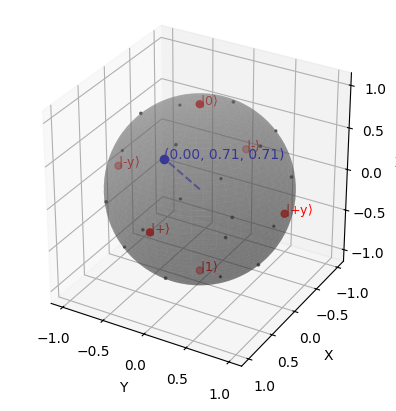

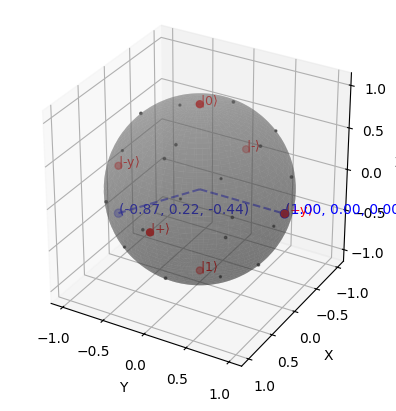

In [27]:
show_states(np.array([zero + plus]))
show_states(np.array([
    plusy,
    [0.5, -2, -1]
]))

## Visualize a (Unitary) Circuit

All unitary circuits (circuits which operate on only one qubit) can be represented as a single rotation of states on the Bloch sphere. By using the `animate_circuit(get_circuit, tracked_points)` function, you can generate an animation of the rotation induced by the circuit. `get_circuit` is a lambda function, shich takes in a prepared circuit and builds on it. `tracked_points` is an optional parameter. You can use it to add points on the sphere you want to track during the rotation. All the points on the Bloch sphere rotate, to show where they end up after to the rotation.

You can use the `num_frames` and `duration` (in seconds) arguments to influence the animation. You can add `save=True` to save the animation as a gif instead of rendering it in the notebook.

What follows are animations of the most common unitary quantum gates.

In [25]:
animate_circuit(lambda c: c.x(0), tracked_points=np.array([[1, 1, 1]]))

In [9]:
animate_circuit(lambda c: c.y(0), tracked_points=np.array([[1, 1, 1]]))

In [10]:
animate_circuit(lambda c: c.z(0), tracked_points=np.array([[1, 1, 1]]))

In [13]:
animate_circuit(lambda c: c.h(0), tracked_points=np.array([zero, plus, -zero, -plus]), coords=False)

## Your own Visualizations

You can add your own vizualizations here.